# Clustering

Author: Koen Kwakkenbos

Version: 1.0

Date: Feb 2022

Notebook used to interactively generate the clusters from the Autoencoder encodings. Due to the stochastic initialization, the script may produce different results. However, the structure in the clustering should be mostly preserved (but sometimes rotated or mirrored).

In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datagenerator import AEDatagen
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import matplotlib.image as mpimg
from matplotlib import cm, colors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [4]:
# Change path to directory where tiles are stored:
TILE_PATH = './Data/Tiles_512/'

In [5]:
# Prepare train and val splits, random seed makes them identical to training situation
patient_data = pd.read_csv('./Seminoma_Outcomes_Anon.csv', header=0, index_col=0)

pat_train, pat_val, y_train, y_val = train_test_split(
    patient_data.index, patient_data['Meta'], test_size=0.25, random_state=42,
    stratify=patient_data['Meta']
)

In [9]:
train_datagen = AEDatagen(list(pat_train), y_train, 224, TILE_PATH, 16, train=False)
val_datagen = AEDatagen(list(pat_val), y_val, 224, TILE_PATH, 16, train=False)

In [10]:
tile_list_train = train_datagen.tile_list
tile_list_val = val_datagen.tile_list

In [11]:
outcome_list_train = train_datagen.tile_outcome_list[:-13]
outcome_list_val = val_datagen.tile_outcome_list[:-10]

In [82]:
# Load the embeddings, can be replaced with VGG1024
X_embedded_train = np.load('./X_train_embedded_VGG512.npy')
X_embedded_val = np.load('./X_val_embedded_VGG512.npy')

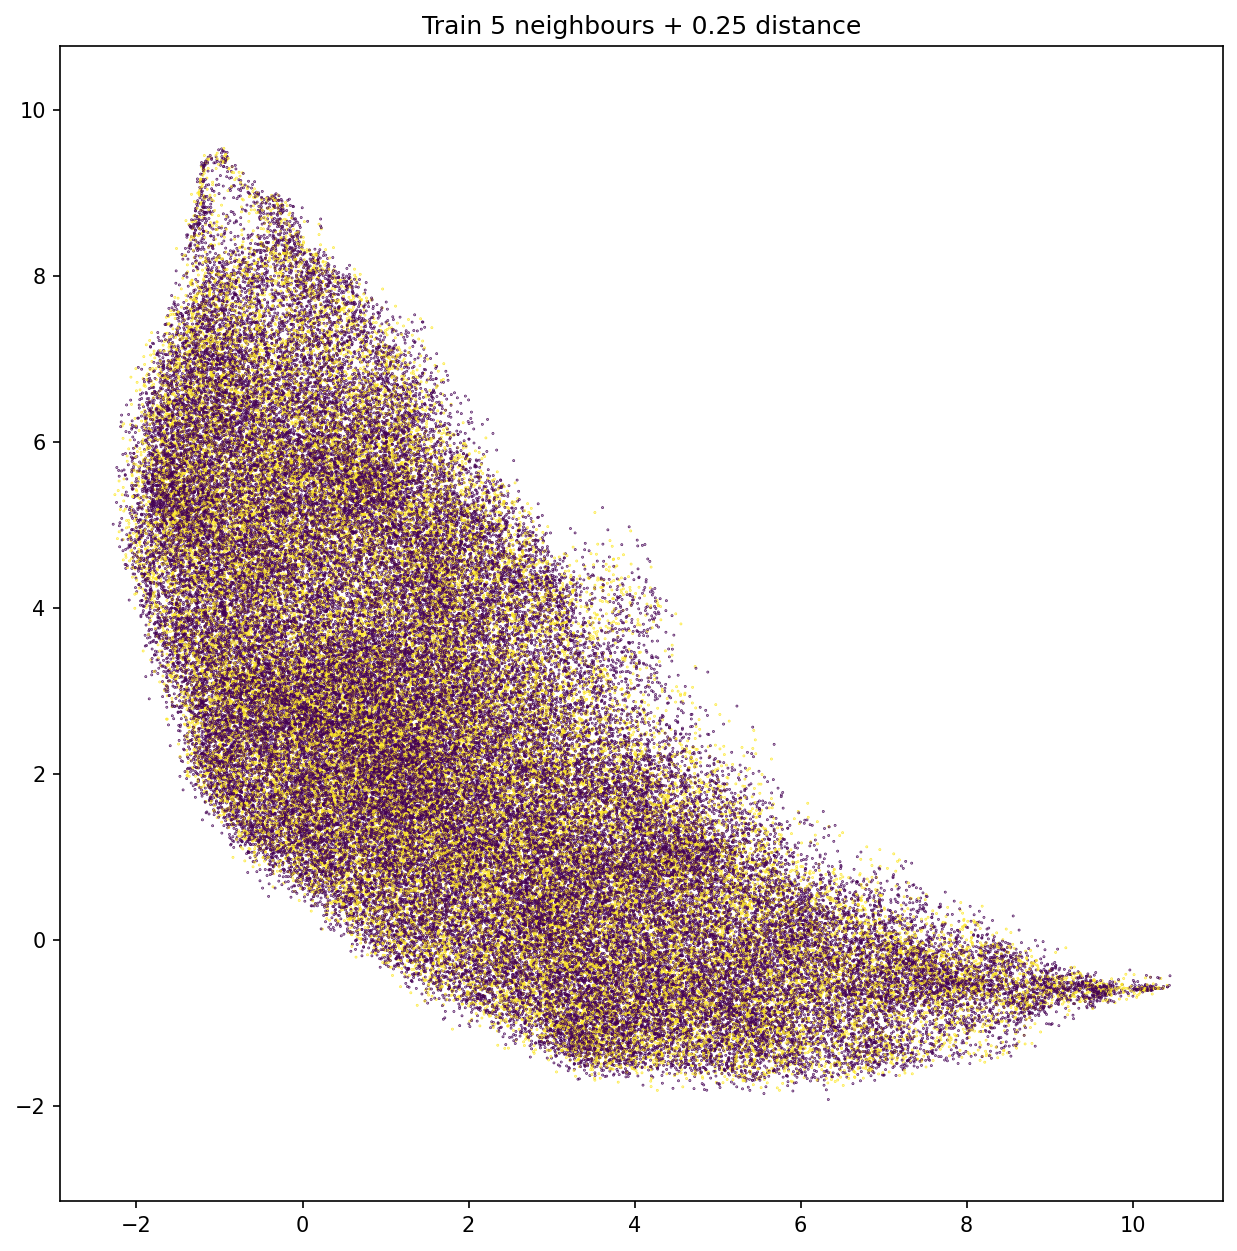

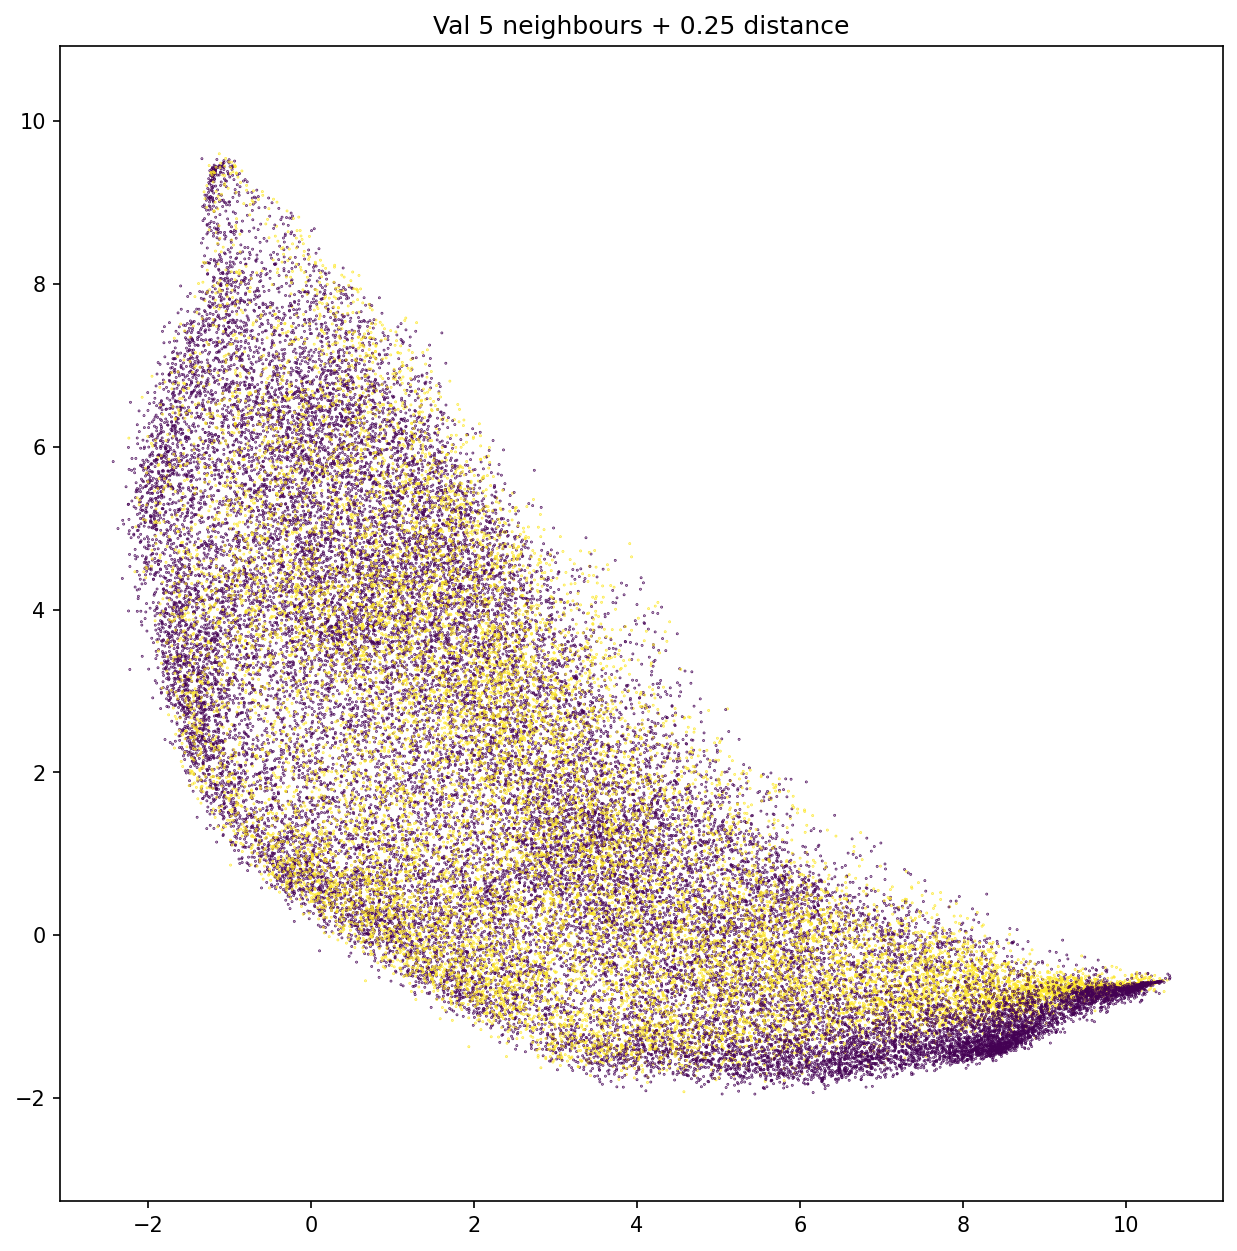

In [87]:
scaler = StandardScaler()
X_embedded_train_s = scaler.fit_transform(X_embedded_train)
X_embedded_val_s = scaler.transform(X_embedded_val)

# To use PCA, uncomment and replace the variables in the code beneath.
# pca = PCA(n_components=10)

# X_embedded_train_spca = pca.fit_transform(X_embedded_train_s)
# X_embedded_val_spca = pca.transform(X_embedded_val_s)

# UMAP experiments, uncomment this to run the nested loop and try all the configurations

for n in (5,): #(5, 10, 20, 50, 100,):
    for d in (0.25,): #(0, 0.1, 0.25, 0.5, 0.9):
        reducer = umap.UMAP(n_neighbors=n, min_dist=d)
        embedding_train = reducer.fit_transform(X_embedded_train_s)

        plt.figure(figsize=(10, 10), dpi=150)
        plt.scatter(
            embedding_train[:, 0],
            embedding_train[:, 1],
            c=outcome_list_train,
            s=0.1
            )
        plt.gca().set_aspect('equal', 'datalim')
        plt.title(f'Train {n} neighbours + {d} distance')

        plt.show()

        embedding_val = reducer.transform(X_embedded_val_s)
        plt.figure(figsize=(10, 10), dpi=150)
        plt.scatter(
            embedding_val[:, 0],
            embedding_val[:, 1],
            c=outcome_list_val,
            s=0.1
        )
        plt.gca().set_aspect('equal', 'datalim')
        plt.title(f'Val {n} neighbours + {d} distance')
        plt.show()

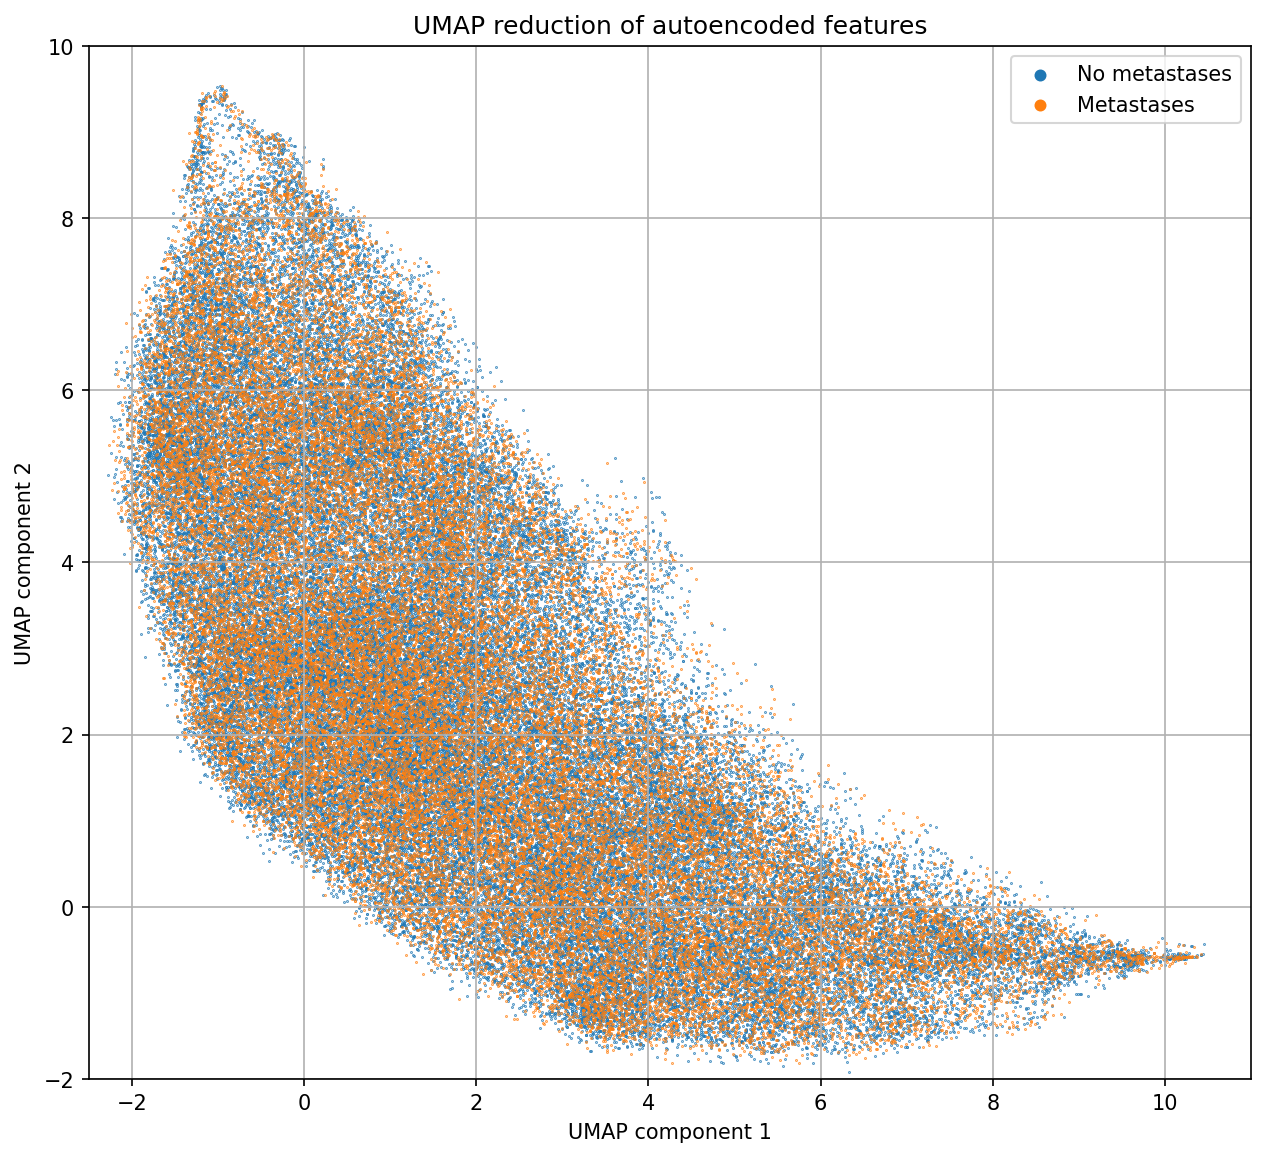

In [94]:
plt.figure(figsize=(10, 10), dpi=150)
meta = ['No metastases', 'Metastases']

for i in range(2):
    row_ix = np.where(np.array(outcome_list_train) == i)[0]
    plt.scatter(
        embedding_train[row_ix, 0],
        embedding_train[row_ix, 1],
        s=0.1,
        label=meta[i]
        )

plt.xlim([-2.5, 11])
plt.ylim([-2, 10])   
plt.gca().set_aspect('equal') 
plt.title(f'UMAP reduction of autoencoded features')
plt.grid()
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.legend(markerscale=15)
plt.show()


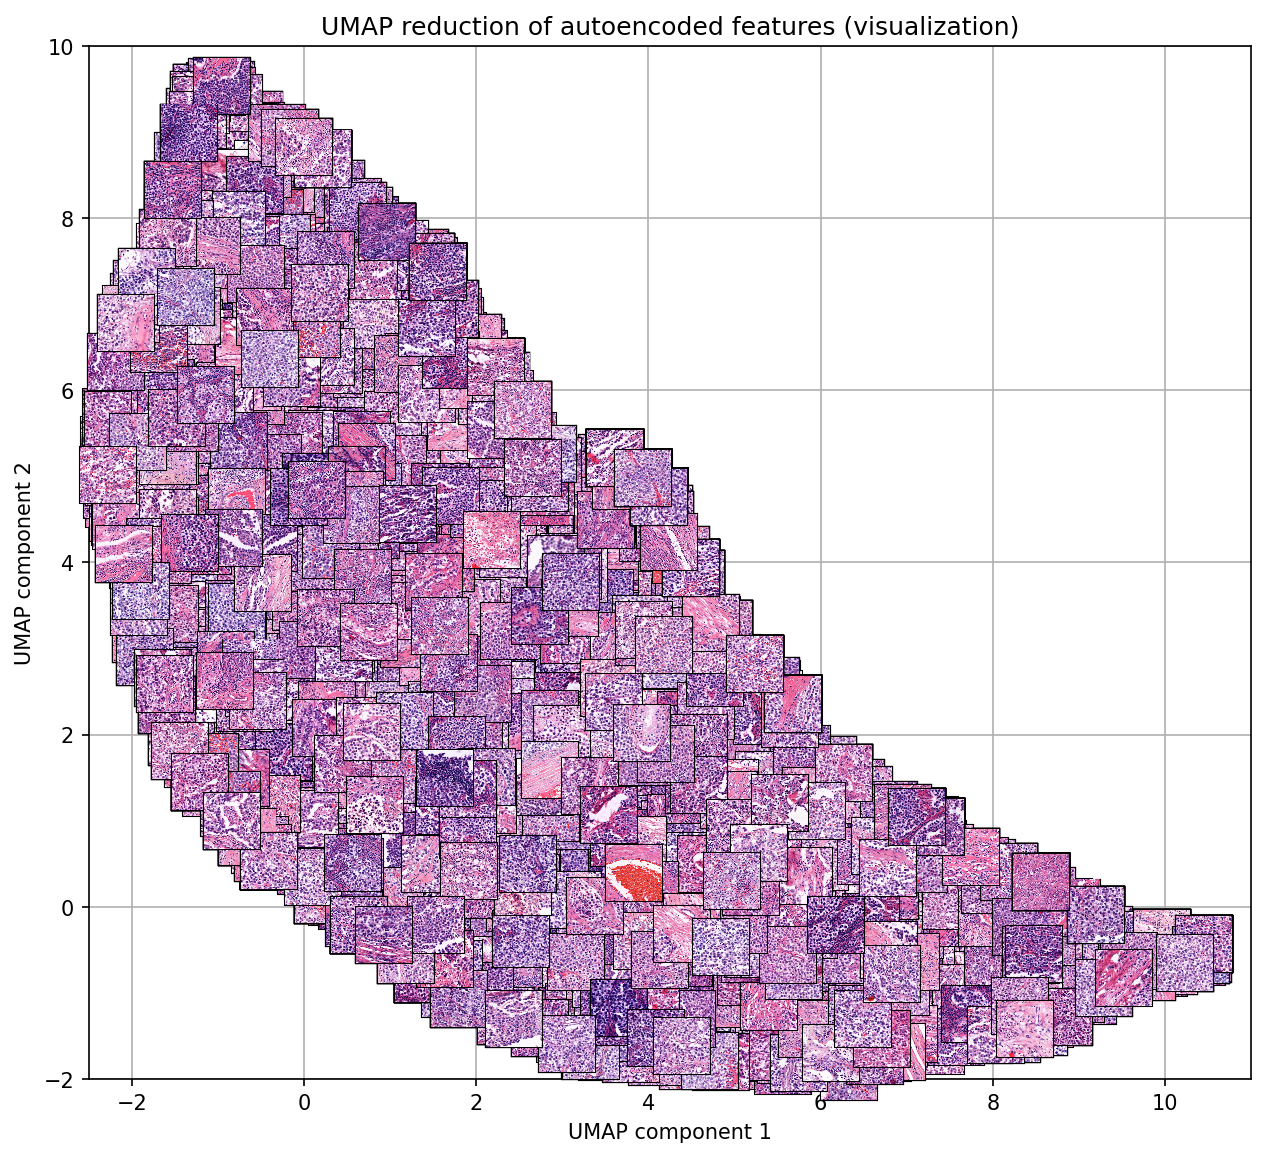

In [96]:
num_images_to_display = 5000

# Create the uniform grid
x_coords = np.linspace(-2.5, 11, num=5000)
y_coords = np.linspace(-2, 10, num=5000)

x_grid, y_grid = np.meshgrid(x_coords, y_coords)
grid_points = np.column_stack([x_grid.ravel(), y_grid.ravel()])

# Randomly sample from the grid
num_samples = 5000 # change this to the number of samples you want
random_indices = np.random.choice(range(grid_points.shape[0]), size=num_samples, replace=False)
random_grid_points = grid_points[random_indices, :]


plt.figure(figsize=(10, 10), dpi=150)
for i in range(random_grid_points.shape[0]):
    x = embedding_train[i, 0]
    y = embedding_train[i, 1]
    closest_index = np.argmin(np.linalg.norm(embedding_train - random_grid_points[i, :], axis=1))
    image = mpimg.imread(tile_list_train[closest_index])
    imagebox = OffsetImage(image, zoom=0.12)
    ab = AnnotationBbox(imagebox, (embedding_train[closest_index, 0], embedding_train[closest_index, 1]), frameon=True, pad=0)#, bboxprops=dict(edgecolor=color_list[closest_index],
                                                                              #linewidth=3))
    plt.gca().add_artist(ab)

plt.xlim([-2.5, 11])
plt.ylim([-2, 10])   
plt.gca().set_aspect('equal') 
plt.title('UMAP reduction of autoencoded features (visualization)')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.grid()
plt.show()